# Import libraries

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

In [2]:
MAIN_DIR = Path('.').absolute().parent
sys.path.append(str(MAIN_DIR))
from dynosarc.dynamic import utils as utl
from dynosarc.dynamic import dynorc

# Directories and file names

In [3]:
DATA_DIR = MAIN_DIR / 'data'
RESULTS_DIR = MAIN_DIR / 'results'

In [4]:
SUBTYPES_FNAME = DATA_DIR / 'subtypes.csv'  

RNA_HPRD_FNAME = DATA_DIR / 'rna_hprd.csv'  

E_HPRD_ONCOKB_FNAME = DATA_DIR / 'genes_network.csv' 

In [5]:
DYNO_RESULTS_DIR = RESULTS_DIR / 'dyno_results'

if not DYNO_RESULTS_DIR.is_dir():
    DYNO_RESULTS_DIR.mkdir()    

# Load data

In [6]:
subtypes = pd.read_csv(SUBTYPES_FNAME, header=0, index_col=0)
subtypes = subtypes['subtype']

In [7]:
lut = {'DSRCT': 'darkblue', 'Ewing Sarcoma': 'darkgreen', 'Osteosarcoma': 'orange', 'Embryonal RMS': 'purple'}
subtype_colors = subtypes.replace(lut).to_frame(name='Subtype')

In [8]:
# # graph:
# E_onco = pd.read_csv(E_HPRD_ONCOKB_FNAME, header=0, index_col=None)
# G_onco = nx.from_pandas_edgelist(E_onco)
# print(G_onco)
E = pd.read_csv(DATA_DIR/'ews_network.csv', header=0)
display(E)
G = nx.from_pandas_edgelist(W, 'node1','node2',edge_attr='weight')


,node1,node2,weight
0,ACTG1,ARID1A,0.841
1,ACTG1,DCTN1,0.442
2,ACTG1,PPP1CB,0.474
3,AFF1,MLLT1,0.999
4,AFF1,LASP1,0.503
...,...,...,...
511,ZRSR2,PPM1D,0.420
512,ZRSR2,KDM6A,0.591
513,ZRSR2,SMC1A,0.658
514,ZRSR2,ETV6,0.699


NameError: name 'W' is not defined

In [ ]:
# RNA-Seq expression profiles:
data = pd.read_csv(RNA_HPRD_FNAME, header=0, index_col=0)
data = data[subtypes.index.copy()]

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\cmu_sem2\\dynosarc\\data\\rna_hprd.csv'

# Helper functions for dynamic analysis

In [ ]:
#don't need
def subtype_ids(subtypes, subtype):
    """ Return ids of samples in specified subtype
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
        
    Return
    ------
    sids : list
        List of ids of samples in specified subtype.
    """        
        
    if subtype == 'EWS': 
        subtype = 'Ewing Sarcoma'
    elif subtype == 'OST':
        subtype = 'Osteosarcoma'
    elif subtype == 'ERMS':
        subtype = 'Embryonal RMS'
    elif subtype == 'DSRCT':
        pass
    else:
        raise ValueError("Unrecognized subtype, must be one of ['EWS', 'OST', 'DSRCT', 'ERMS'].")
            
    sids = subtypes.loc[subtypes==subtype].index.tolist()    
    return sids

In [ ]:
def subtype_data(subtypes, subtype, return_copy=True):
    """ Return RNA expression profiles for samples in the specified subtype 
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
    return_copy : bool
        If True, return copy of original data.
        
    Return
    ------
    data : Pandas DataFrame
        Subset of data for samples in specified cohort.
        """
    samples = subtype_ids(subtypes, subtype)
    gl = list(G)
            
    if return_copy:
        return data.loc[gl, samples].copy()
    else:
        return data.loc[gl, samples]

In [ ]:
def weighted_network(subtypes, subtype, **corr_kws):
    """ return subtype specific weighted network 
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
    graph : {'onco', 'hprd'}
        Graph topology.
    corr_kws : dict
        Keyword arguments for computed weighted network.
        
    Returns
    -------
    s_weights : Pandas DataFrame
        Dataframe with 3 columns including source, target, weight of the network (where weights correspond to distance).
    """
    s_data = subtype_data(subtypes, subtype)
    edgelist = E
            
    return utl.distance_weights(s_data, edgelist, **corr_kws)

In [ ]:
file_ids = {"EWS": "ewing", "OST": "osteo", "DSRCT": "dsrct"}

def get_directory_prefix(subtype):            
    return "_".join([subtype, 'oncoKB', str(len(G))])


def cohort_curvature_simulation(subtype, W, crit=0.75, directory=None,
                                force_recompute=False, chunksize=None, edgelist=None, **dyn_kws):
    """ load data and compute dynamic curvature analysis """
    
    if directory is None:
        directory = DYNO_RESULTS_DIR / get_directory_prefix(subtype)
    G = nx.from_pandas_edgelist(W, 'node1','node2',edge_attr='weight')
    dyno = utl.run_curvature_simulation(str(directory), G, crit=crit, chunksize=chunksize, edgelist=edgelist,
                                        force_recompute=force_recompute, **dyn_kws)
    return dyno
        
            
def get_cohort_curvature_simulation_results(subtype, crit=0.75, directory=None,
                                            **dyn_kws):
    """ load DORC simulation """   
    if directory is None:
        directory = DYNO_RESULTS_DIR / get_directory_prefix(subtype)    
    dyno = utl.load_curvature_simulation(str(directory), crit=crit, **dyn_kws)
    return dyno    

# Dynamic curvature analysis

We demonstrate how to perform the dynamic curvature simulation on the EWS network

## Construct weighted network

In [ ]:
subtype_cur = 'EWS'

In [ ]:
# data_cur = subtype_data(subtypes, subtype_cur)
W_cur= pd.read_csv(DATA_DIR/'ews_network.csv')

# corr_kws_cur = {'method': 'pearson', 
#                 'min_samples': data.shape[1] - 3,       
#                 'thresh': 0.03, 
#                 'std_thresh': 3}

# W_cur = weighted_network(subtypes, subtype_cur, **corr_kws_cur)

## Run dynamic simulation

In [ ]:
dyn_kws = dict(times=None, 
               t_min=-2.2,
               t_max=2.0, # 1.7
               n_t=55, # 50
               log_time=True,
               use_spectral_gap=False,
               e_weight="weight",
               verbose="INFO",
              )

dynamic.utils: 04/21/2024 03:03:18  AM | INFO | utils.py:run_curvature_simulation:155 | 26732 >>> Create directory to store dynamic simulation results: c:\cmu_sem2\dynosarc\results\dyno_results\EWS_oncoKB_78
dynamic.dynorc: 04/21/2024 03:03:18  AM | WARNING | dynorc.py:__init__:510 | 26732 >>> Graph is not connected, reduce to largest connected component instead
dynamic.utils: 04/21/2024 03:03:18  AM | INFO | utils.py:run_curvature_simulation:159 | 26732 >>> Dynamic curvature simulation to be computed on 256 edges.
dynamic.dynorc: 04/21/2024 03:03:18  AM | INFO | dynorc.py:compute_dynamic_curvatures:578 | 26732 >>> Computing geodesic distances
dynamic.dynorc: 04/21/2024 03:03:18  AM | INFO | dynorc.py:compute_dynamic_curvatures:601 | 26732 >>> No prior partial simulation detected, the full dynamic curvature simulation will be computed
dynamic.dynorc: 04/21/2024 03:03:18  AM | INFO | dynorc.py:_compute_dynamic_curvatures:335 | 26732 >>> Constructing Laplacian
dynamic.dynorc: 04/21/2024 

Dynamic simulation: 100%|██████████| 55/55 [00:10<00:00,  5.00it/s]


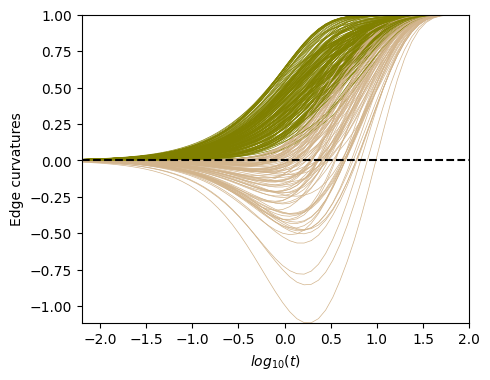

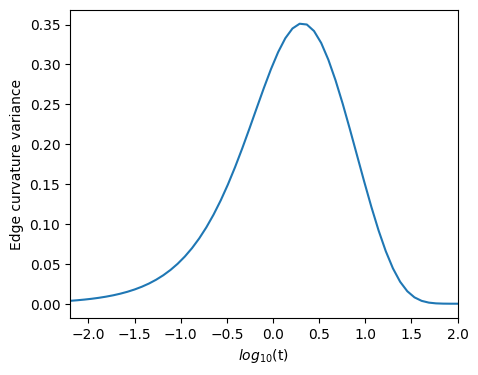

In [ ]:
# Only run once (load saved results next)
cohort_curvature_simulation(subtype_cur, W_cur, **dyn_kws)

## Load dynamic simulation resuls

In [ ]:
dyno_cur = get_cohort_curvature_simulation_results(subtype_cur, crit=0.75, **dyn_kws)

## Critical curvature filter

In [ ]:
G_sub = dyno_cur.G.copy()
G_sub.remove_edges_from([ee for ee, vl in nx.get_edge_attributes(dyno_cur.G, 'kappa_critical').items() if vl<0.0])

In [ ]:
# size of remaining fucntionally associated network: 
print(G_sub)

Graph with 74 nodes and 205 edges


In [ ]:
# Remaining genes functionally associated with EWSR1, FLI1 and ETV6:

for gn in ['EWSR1', 'FLI1', 'ETV6']:
    gn_nbrs = [G_sub.nodes[k]['name'] for k in list(G_sub.neighbors(dyno_cur.get_node_index(gn)))]
    print(f"Functional neighbors of {gn}:", gn_nbrs)

Functional neighbors of EWSR1: ['ARID1A', 'ETV6', 'U2AF1', 'FUBP1', 'TLE1', 'POU5F1', 'PATZ1', 'U2AF2', 'SOX2', 'PAX7', 'TAF15', 'NR4A3', 'FLI1']
Functional neighbors of FLI1: ['ETV6', 'EWSR1']
Functional neighbors of ETV6: ['AFF1', 'MLLT1', 'KDM6A', 'ZNF384', 'CHIC2', 'STAG2', 'U2AF1', 'ZRSR2', 'FLI1', 'EWSR1']


## Multi-scale functional clustering

In [ ]:
attr = 'wavg_kappa_critical'
cut_uniform=True
thresh_cut=0.0
mx_bump=0

cc_fname = str(Path(dyno_cur.directory) / f"CCrecord_{attr}_cut_uniform_{cut_uniform}_cut_start_{'negative' if thresh_cut<0 else '0'}.csv")
CCrecord_cur, CCdist_cur, linkage_cur = utl.community_hierarchy(dyno_cur.G,
                                                                         attr=attr,
                                                                         method='ward',
                                                                         optimal_ordering=True,
                                                                         cut_uniform=cut_uniform,
                                                                         thresh_cut=thresh_cut,
                                                                         mx_bump=0,
                                                                         cc_fname=cc_fname)

100%|██████████| 4849/4849 [00:01<00:00, 3070.17it/s]

dynamic.utils: 04/21/2024 03:07:34  AM | INFO | utils.py:community_hierarchy:285 | 26732 >>> CCrecord saved to c:\cmu_sem2\dynosarc\results\dyno_results\EWS_oncoKB_78\CCrecord_wavg_kappa_critical_cut_uniform_True_cut_start_0.csv


['ERCC5', 'XPA', 'FANCA', 'FANCG', 'FANCF', 'FANCC', 'FANCD2', 'FANCE', 'MUTYH', 'NTHL1', 'MSH6', 'POLE', 'MAD2L2', 'BRCA2', 'TRAF7', 'SUFU', 'SPOP', 'CYLD', 'NOD1', 'CASP8', 'MYD88', 'DKK1', 'DKK2', 'LRP6', 'LRP5', 'RALGDS', 'RRAS', 'PPP1CB', 'CACNA1D', 'DDIT3', 'CYP19A1', 'MAP2K4', 'ACTG1', 'TLE1', 'TLX1', 'STK19', 'TRIP13', 'RPL5', 'RAD21', 'SMC1A', 'STAG2', 'STAG1', 'LMNA', 'FUBP1', 'U2AF2', 'ZRSR2', 'U2AF1', 'SIX1', 'PAX7', 'IGF2', 'GPC3', 'FGF10', 'SOX2', 'POU5F1', 'NUMA1', 'CLIP1', 'DCTN1', 'EWSR1', 'FLI1', 'TAF15', 'NR4A3', 'PATZ1', 'AFF1', 'MLLT1', 'CHIC2', 'PRCC', 'ARID1A', 'KDM6A', 'FGFR2', 'ZNF384', 'ETV6', 'LASP1', 'BACH2', 'PPM1D']


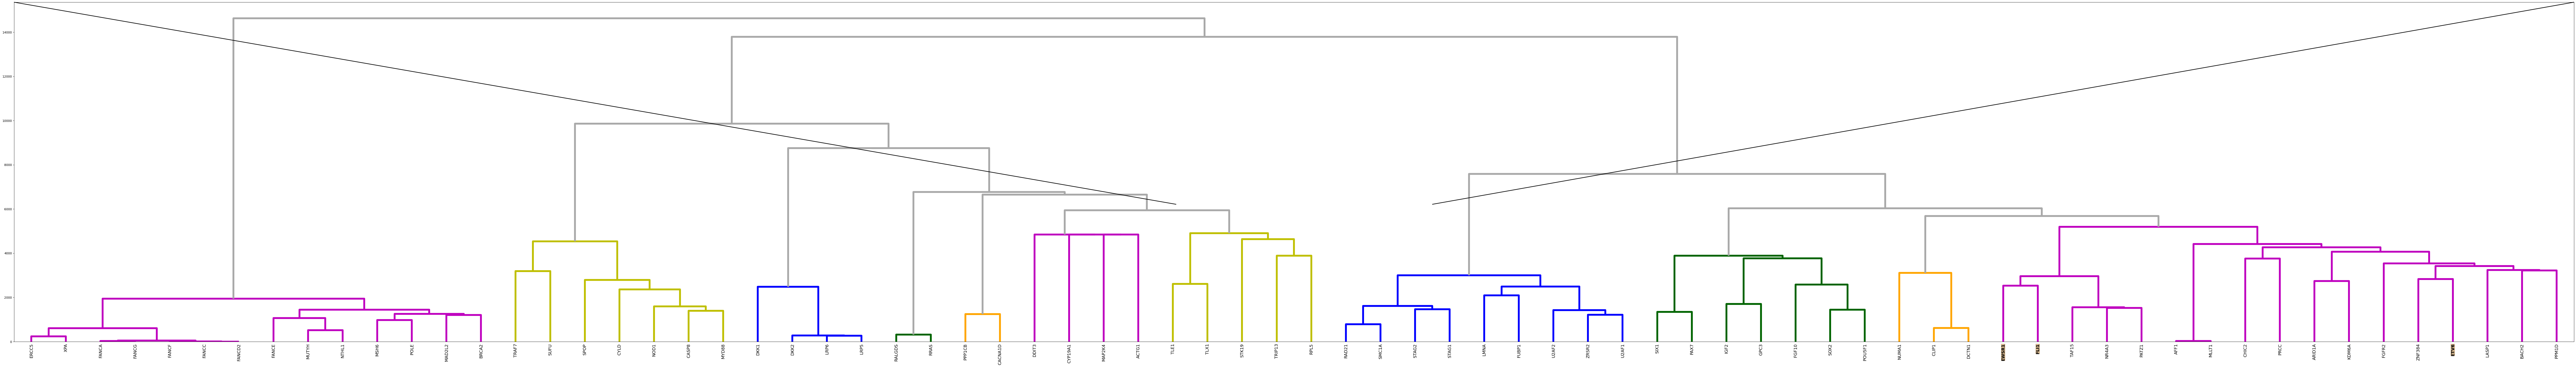

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))

hc.set_link_color_palette(['m', 'y', 'b', 'darkgreen', 'orange'])
plt.rcParams['lines.linewidth'] = 0.7
nodes = hc.dendrogram(linkage_cur, ax=ax,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      no_labels=True,
                      # leaf_font_size=4,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)

axins = zoomed_inset_axes(ax, 10, loc='lower center',                           
                          bbox_to_anchor=(-0.34, -3.09, 1.6, 0.3), bbox_transform=ax.transAxes)

plt.rcParams['lines.linewidth'] = 6
_ = hc.dendrogram(linkage_cur, ax=axins,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      leaf_font_size=14,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)



xlbls = axins.get_xmajorticklabels()
for lbl in xlbls:
    ll = lbl.get_text()
    if ll in ['EWSR1', 'FLI1', 'ETV6']: 
        lbl.set_fontweight('bold');
        lbl.set_bbox(dict(facecolor='tan', alpha=1., linewidth=0, pad=0.))


# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=1, loc2=2,
           fc="none", ec='k', lw=2, zorder=5)

ax.set_title(subtype_cur, fontsize=32, fontweight='bold', loc='right', y=0.72);
print(nodes['ivl'])





In [ ]:
[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))]

['ACTG1',
 'ARID1A',
 'DCTN1',
 'PPP1CB',
 'AFF1',
 'MLLT1',
 'LASP1',
 'KDM6A',
 'ZNF384',
 'ETV6',
 'STAG2',
 'MSH6',
 'U2AF1',
 'MAP2K4',
 'FUBP1',
 'TLE1',
 'FGFR2',
 'EWSR1',
 'BRCA2',
 'POLE',
 'SOX2',
 'BACH2',
 'PATZ1',
 'TRIP13',
 'NTHL1',
 'FANCE',
 'MAD2L2',
 'FANCD2',
 'FANCC',
 'RAD21',
 'PPM1D',
 'SMC1A',
 'FANCF',
 'LMNA',
 'XPA',
 'FANCG',
 'SPOP',
 'CYP19A1',
 'MUTYH',
 'ERCC5',
 'FANCA',
 'CACNA1D',
 'CASP8',
 'NOD1',
 'DDIT3',
 'MYD88',
 'CYLD',
 'CHIC2',
 'FGF10',
 'CLIP1',
 'NUMA1',
 'TRAF7',
 'IGF2',
 'RPL5',
 'DKK1',
 'POU5F1',
 'LRP6',
 'DKK2',
 'LRP5',
 'GPC3',
 'ZRSR2',
 'TLX1',
 'FLI1',
 'U2AF2',
 'PAX7',
 'TAF15',
 'NR4A3',
 'SIX1',
 'STAG1',
 'PRCC',
 'STK19',
 'RRAS',
 'RALGDS',
 'SUFU']

['ERCC5', 'XPA', 'FANCA', 'FANCG', 'FANCF', 'FANCC', 'FANCD2', 'FANCE', 'MUTYH', 'NTHL1', 'MSH6', 'POLE', 'MAD2L2', 'BRCA2', 'TRAF7', 'SUFU', 'SPOP', 'CYLD', 'NOD1', 'CASP8', 'MYD88', 'DKK1', 'DKK2', 'LRP6', 'LRP5', 'RALGDS', 'RRAS', 'PPP1CB', 'CACNA1D', 'DDIT3', 'CYP19A1', 'MAP2K4', 'ACTG1', 'TLE1', 'TLX1', 'STK19', 'TRIP13', 'RPL5', 'RAD21', 'SMC1A', 'STAG2', 'STAG1', 'LMNA', 'FUBP1', 'U2AF2', 'ZRSR2', 'U2AF1', 'SIX1', 'PAX7', 'IGF2', 'GPC3', 'FGF10', 'SOX2', 'POU5F1', 'NUMA1', 'CLIP1', 'DCTN1', 'EWSR1', 'FLI1', 'TAF15', 'NR4A3', 'PATZ1', 'AFF1', 'MLLT1', 'CHIC2', 'PRCC', 'ARID1A', 'KDM6A', 'FGFR2', 'ZNF384', 'ETV6', 'LASP1', 'BACH2', 'PPM1D']


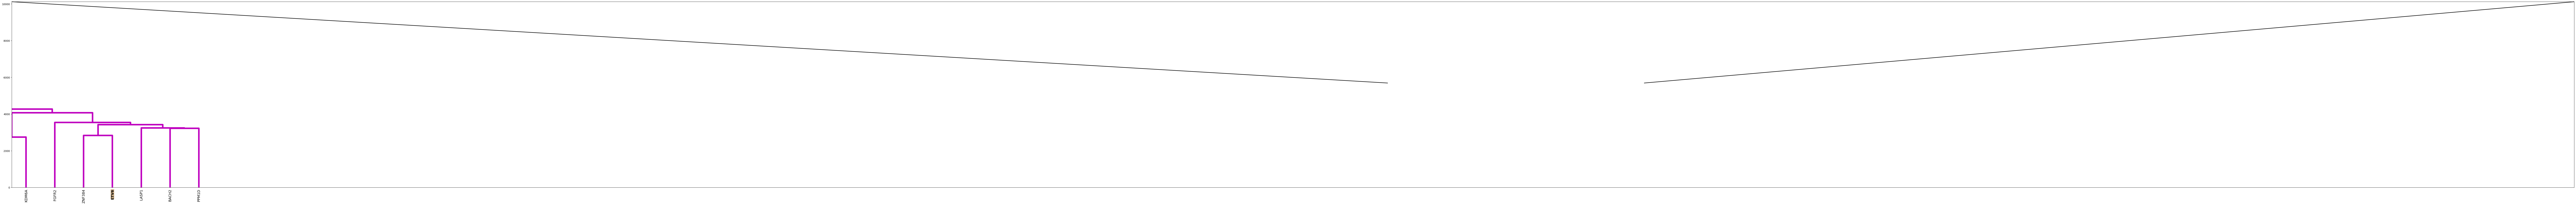

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))

hc.set_link_color_palette(['m', 'y', 'b', 'darkgreen', 'orange'])
plt.rcParams['lines.linewidth'] = 0.7
nodes = hc.dendrogram(linkage_cur, ax=ax,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      no_labels=True,
                      # leaf_font_size=4,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)

axins = zoomed_inset_axes(ax, 10, loc='lower center',                           
                          bbox_to_anchor=(-0.34, -3.09, 1.6, 0.3), bbox_transform=ax.transAxes)

plt.rcParams['lines.linewidth'] = 6
_ = hc.dendrogram(linkage_cur, ax=axins,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      leaf_font_size=14,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)

# sub region of the original image
x1, x2, y1, y2 = 670., 1560, 0., 10120.0,
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

xlbls = axins.get_xmajorticklabels()
for lbl in xlbls:
    ll = lbl.get_text()
    if ll in ['EWSR1', 'FLI1', 'ETV6']: 
        lbl.set_fontweight('bold');
        lbl.set_bbox(dict(facecolor='tan', alpha=1., linewidth=0, pad=0.))

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=1, loc2=2,
           fc="none", ec='k', lw=2, zorder=5)

ax.set_title(subtype_cur, fontsize=32, fontweight='bold', loc='right', y=0.72);
print(nodes['ivl'])

        
        
for gn in ['EWSR1', 'FLI1' ,'ETV6', 'WT1']:
    
    # indices in nodes ivl where gn 
    # k=[]
    # for i in nodes['ivl']:
    #     if i == gn:
    #         k+=i
    # a = [k][0]
    xx = 5 + 10*4
    yy = 14000 if gn in ['WT1', 'ETV6'] else 18000 if gn=='FLI1' else 22000 
    ax.annotate(gn, xy=(xx, yy))
    ax.axvline(xx, c='gray', ls='-.', lw=0.2, marker='d');

# fig.dpi=600
# fig.savefig(MAIN_DIR / 'figures' / 'dyno_EWS_ms_persistent_clustering.png', 
#            dpi=300, bbox_inches='tight', bbox_extra_artists=(ax, axins))

plt.rcParams['lines.linewidth'] = 1.5  # return to matplotlib default line width 
hc.set_link_color_palette(None)  # reset to default after use          


Curvature and Gene Knockout Simulations

In [9]:
from dynosarc.dynamic import dynorc

In [91]:
W= pd.read_csv(DATA_DIR/'ews_network.csv')

G = nx.from_pandas_edgelist(W, 'node1','node2',edge_attr='weight')

# Create a mapping from string labels to integers
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}

# Create a new graph with integer node labels
G = nx.relabel_nodes(G, node_mapping)

# Print the mapping between string and integer labels
print("String to Integer Mapping:")
print(node_mapping)

# Print the edges of the new graph with integer labels
print("\nEdges of the New Graph with Integer Labels:")
print(G.edges())
# {'ACTG1': 0, 'ARID1A': 1, 'DCTN1': 2, 'PPP1CB': 3, 'AFF1': 4, 'MLLT1': 5, 'LASP1': 6, 'KDM6A': 7, 'ZNF384': 8, 'ETV6': 9, 'APH1A': 10, 'NCSTN': 11, 'STAG2': 12, 'MSH6': 13, 'U2AF1': 14, 'MAP2K4': 15, 'FUBP1': 16, 'TLE1': 17, 'FGFR2': 18, 'EWSR1': 19, 'BRCA2': 20, 'POLE': 21, 'SOX2': 22, 'BACH2': 23, 'PATZ1': 24, 'TRIP13': 25, 'NTHL1': 26, 'FANCE': 27, 'MAD2L2': 28, 'FANCD2': 29, 'FANCC': 30, 'RAD21': 31, 'PPM1D': 32, 'SMC1A': 33, 'FANCF': 34, 'LMNA': 35, 'XPA': 36, 'FANCG': 37, 'SPOP': 38, 'CYP19A1': 39, 'MUTYH': 40, 'ERCC5': 41, 'FANCA': 42, 'CACNA1D': 43, 'CASP8': 44, 'NOD1': 45, 'DDIT3': 46, 'MYD88': 47, 'CYLD': 48, 'CHIC2': 49, 'FGF10': 50, 'CLIP1': 51, 'NUMA1': 52, 'TRAF7': 53, 'IGF2': 54, 'RPL5': 55, 'DKK1': 56, 'POU5F1': 57, 'LRP6': 58, 'DKK2': 59, 'LRP5': 60, 'GPC3': 61, 'ZRSR2': 62, 'TLX1': 63, 'FLI1': 64, 'U2AF2': 65, 'PAX7': 66, 'TAF15': 67, 'NR4A3': 68, 'SIX1': 69, 'STAG1': 70, 'PRCC': 71, 'STK19': 72, 'RRAS': 73, 'PTPRD': 74, 'PTPRS': 75, 'RALGDS': 76, 'SUFU': 77}
#  EWSR1: 19
# FLI1: 64
# ETV6: 9
# nx.get_edge_attributes(G,"weight")

String to Integer Mapping:
{'ACTG1': 0, 'ARID1A': 1, 'DCTN1': 2, 'PPP1CB': 3, 'AFF1': 4, 'MLLT1': 5, 'LASP1': 6, 'KDM6A': 7, 'ZNF384': 8, 'ETV6': 9, 'APH1A': 10, 'NCSTN': 11, 'STAG2': 12, 'MSH6': 13, 'U2AF1': 14, 'MAP2K4': 15, 'FUBP1': 16, 'TLE1': 17, 'FGFR2': 18, 'EWSR1': 19, 'BRCA2': 20, 'POLE': 21, 'SOX2': 22, 'BACH2': 23, 'PATZ1': 24, 'TRIP13': 25, 'NTHL1': 26, 'FANCE': 27, 'MAD2L2': 28, 'FANCD2': 29, 'FANCC': 30, 'RAD21': 31, 'PPM1D': 32, 'SMC1A': 33, 'FANCF': 34, 'LMNA': 35, 'XPA': 36, 'FANCG': 37, 'SPOP': 38, 'CYP19A1': 39, 'MUTYH': 40, 'ERCC5': 41, 'FANCA': 42, 'CACNA1D': 43, 'CASP8': 44, 'NOD1': 45, 'DDIT3': 46, 'MYD88': 47, 'CYLD': 48, 'CHIC2': 49, 'FGF10': 50, 'CLIP1': 51, 'NUMA1': 52, 'TRAF7': 53, 'IGF2': 54, 'RPL5': 55, 'DKK1': 56, 'POU5F1': 57, 'LRP6': 58, 'DKK2': 59, 'LRP5': 60, 'GPC3': 61, 'ZRSR2': 62, 'TLX1': 63, 'FLI1': 64, 'U2AF2': 65, 'PAX7': 66, 'TAF15': 67, 'NR4A3': 68, 'SIX1': 69, 'STAG1': 70, 'PRCC': 71, 'STK19': 72, 'RRAS': 73, 'PTPRD': 74, 'PTPRS': 75, 'RALGDS

In [11]:
# apply or curvature on weighted graph 
# dynamic diffusion process? 
# geodesic_distances = dynorc._compute_distance_geodesic(G,weight='weight')


# nx.set_edge_attributes(G, {(v0, v1): geodesic_distances[v0, v1].item() for v0, v1 in G.edges()}, name="distance")
# measures: list
# geodes dists : list
# measures = list(np.eye(len(G)))

# turn nodes into numbers instead of string names
# edge = ('EWSR1','FLI1')
edge = (19,64)
times = dynorc._get_times()


In [12]:
dynorc._compute_dynamic_curvatures(G,times=times,edgelist=[edge])

Dynamic simulation:  30%|███       | 6/20 [00:08<00:14,  1.00s/it]

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [

Dynamic simulation: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [

source,19
target,64
0.031623,0.0
0.042813,0.0
0.057964,0.0
0.078476,0.0
0.106247,0.0
0.143845,0.0
0.194748,0.0
0.263665,0.0
0.356970,0.0


In [13]:
geodesic_distances = dynorc._compute_distance_geodesic(G,weight='weight')

measures = list(np.eye(len(G)))
# 
geodesic_distances[19,64]


0.912

In [14]:
nx.set_edge_attributes(G, {(v0, v1): geodesic_distances[v0, v1].item() for v0, v1 in G.edges()}, name="distance")

dynorc._edge_curvature(edge,measures=measures, geodesic_distances=geodesic_distances)


wass:
0.912
curv
0.0


(0.0, 0.912)

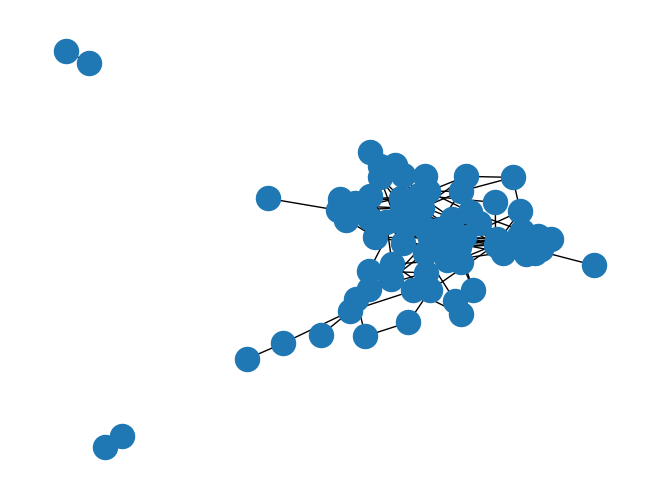

In [112]:
nx.draw_spring(G)

In [ ]:
# nx.get_edge_attributes(G,"distance")

{(0, 1): 0.841,
 (0, 2): 0.442,
 (0, 3): 0.474,
 (1, 12): 0.556,
 (1, 13): 0.726,
 (1, 14): 0.483,
 (1, 15): 0.403,
 (1, 16): 0.426,
 (1, 17): 0.452,
 (1, 18): 0.592,
 (1, 19): 0.606,
 (1, 20): 0.663,
 (1, 21): 0.672,
 (1, 7): 0.675,
 (1, 22): 0.741,
 (2, 51): 0.999,
 (2, 52): 0.794,
 (3, 43): 0.907,
 (3, 12): 0.431,
 (3, 73): 0.53,
 (4, 5): 0.9339999999999999,
 (4, 6): 0.503,
 (4, 7): 0.404,
 (4, 8): 0.473,
 (4, 9): 0.715,
 (5, 9): 0.512,
 (5, 6): 0.484,
 (5, 8): 0.461,
 (6, 25): 0.565,
 (7, 9): 0.445,
 (7, 27): 0.498,
 (7, 12): 0.722,
 (7, 13): 0.446,
 (7, 57): 0.561,
 (7, 14): 0.505,
 (7, 31): 0.429,
 (7, 62): 0.591,
 (7, 33): 0.57,
 (7, 22): 0.79,
 (7, 55): 0.604,
 (7, 17): 0.535,
 (7, 47): 0.678,
 (8, 9): 0.645,
 (8, 19): 0.461,
 (8, 60): 0.414,
 (8, 71): 0.475,
 (8, 22): 0.499,
 (9, 49): 0.853,
 (9, 12): 0.612,
 (9, 58): 0.515,
 (9, 14): 0.682,
 (9, 60): 0.403,
 (9, 31): 0.477,
 (9, 62): 0.699,
 (9, 33): 0.481,
 (9, 35): 0.427,
 (9, 63): 0.511,
 (9, 64): 0.419,
 (9, 19): 0.548,
 

In [ ]:
# try with library


In [37]:

import networkx as nx
import numpy as np
import math
import importlib

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics



In [33]:
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")
orc.compute_ricci_curvature_edges(edge_list=[(19,64)])
# G_orc = orc.G.copy()  # save an intermediate result

TRACE:Number of nodes: 78
TRACE:Number of edges: 258
TRACE:Start to compute all pair shortest path.
TRACE:0.001010 secs for all pair by NetworKit.


ValueError: cannot find context for 'fork'

In [73]:
# nx.get_edge_attributes(G,"weight")

In [92]:
frc = FormanRicci(G)
frc.compute_ricci_curvature()
G_frc = frc.G.copy()  # save an intermediate result
nx.get_edge_attributes(G_frc, name="formanCurvature")


{(0, 1): -15.347262012068644,
 (0, 2): -1.101883491572306,
 (0, 3): -2.503615097517306,
 (1, 12): -13.19679143181058,
 (1, 13): -20.254343225289432,
 (1, 14): -11.17354497320908,
 (1, 15): -8.814390190702587,
 (1, 16): -7.644047412670013,
 (1, 17): -6.226058200024435,
 (1, 18): -8.938725170840826,
 (1, 19): -12.583702450903274,
 (1, 20): -23.09283492860134,
 (1, 21): -18.43289088343364,
 (1, 7): -13.556709648929345,
 (1, 22): -17.636856921934587,
 (2, 51): -0.05504760620432974,
 (2, 52): -1.145354312244406,
 (3, 43): -2.142126426838802,
 (3, 12): -9.351521857376648,
 (3, 73): -1.659139915554645,
 (4, 5): 3.4214979039104123,
 (4, 6): -1.6763196323617342,
 (4, 7): -11.223242780817566,
 (4, 8): -3.657601015375446,
 (4, 9): -11.569555909449287,
 (5, 9): -11.348583775562112,
 (5, 6): -0.6882049325689482,
 (5, 8): -2.5524690659219162,
 (6, 25): -3.10157125240455,
 (7, 9): -12.140928746397341,
 (7, 27): -15.139516040177037,
 (7, 12): -9.889814061140353,
 (7, 13): -13.525844138510017,
 (7, 57)

In [95]:
def show_results(G, curvature="ricciCurvature"):

    # Print the first five results
    # for n1,n2 in list(G.edges())[:5]:
    #     print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures ")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()
    


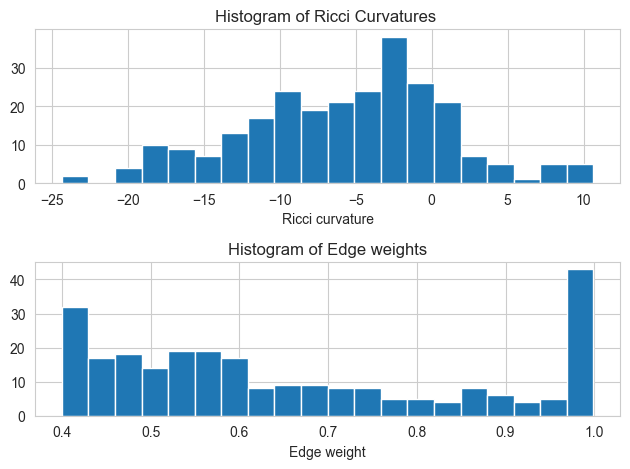

In [102]:
show_results(G_frc,curvature="ricciCurvature")

INFO:Not connected graph detected, compute on the largest connected component instead.
INFO:No ricciCurvature detected, compute original_RC...


ValueError: cannot find context for 'fork'

In [ ]:
EWSR1_FLI1_curv = (orc.compute_ricci_curvature_edges([(19,64)]))[(19,64)]
FLI1_ETV6_curv = (orc.compute_ricci_curvature_edges([(64,9)]))[(64,9)]
EWSR1_ETV6_curv = (orc.compute_ricci_curvature_edges([(19,9)]))[(19,9)]

In [127]:
nodes = G.nodes

EWSR1_FLI1_genes = []
FLI1_ETV6_genes = []
EWSR1_ETV6_genes = []
gene_id = []

for node in nodes :
    if node!= 19 and node!= 64 and node!= 9:
        print(node)
        H = G.subgraph([i for i in nodes if i!=node])
        # compute curvature of this graph 
        H_orc = OllivierRicci(H, alpha=0.5, verbose="TRACE")
        EWSR1_FLI1_curv_H = (H_orc.compute_ricci_curvature_edges([(19,64)]))[(19,64)]
        FLI1_ETV6_curv_H = (H_orc.compute_ricci_curvature_edges([(64,9)]))[(64,9)]
        EWSR1_ETV6_curv_H = (H_orc.compute_ricci_curvature_edges([(19,9)]))[(19,9)]

        

        EWSR1_FLI1_delta = (EWSR1_FLI1_curv - EWSR1_FLI1_curv_H)
        FLI1_ETV6_delta = (FLI1_ETV6_curv - FLI1_ETV6_curv_H)
        EWSR1_ETV6_delta = (EWSR1_ETV6_curv - EWSR1_ETV6_curv_H)

        # if node ==0: 
        #     print(EWSR1_FLI1_curv_H)
        #     print(FLI1_ETV6_curv_H)
        #     print(EWSR1_ETV6_curv_H)
        #     print("delta")
        #     print(EWSR1_FLI1_delta)
        #     print(FLI1_ETV6_delta)
        #     print(EWSR1_ETV6_delta)

        if abs(EWSR1_FLI1_delta) >.00001 or abs(FLI1_ETV6_delta) >.00001 or abs(EWSR1_ETV6_delta)>.00001
            EWSR1_FLI1_genes.append(EWSR1_FLI1_delta)
            FLI1_ETV6_genes.append(FLI1_ETV6_delta)
            EWSR1_ETV6_genes.append(EWSR1_ETV6_delta)
            gene_id.append(node)

# lists of nodes, 
EWSR1_FLI1_genes 
FLI1_ETV6_genes 
EWSR1_ETV6_genes 

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
  

print(len(EWSR1_FLI1_genes ))
print(len(FLI1_ETV6_genes ))
print(len(EWSR1_ETV6_genes ))

# Read in the DataFrame 
# df has columns with delta for each of the 3 
# rows are genes 
node_mapping = dict((v,k) for k,v in  node_mapping.items())

gene_id = [node_mapping[n] for n in gene_id]

df = pd.DataFrame({'id':gene_id, 'EWSR-FLI1':EWSR1_FLI1_genes  , 'FLI-ETV6':FLI1_ETV6_genes, 'EWSR1-ETV6':EWSR1_ETV6_genes })
df = df.sort_values('EWSR-FLI1')
# creating a bar 
plt.title("Gene Knockout Effects")
plt.ylabel("Change in Curvature ")
plt.xlabel("Genes")

df.plot(x = 'id', y=['EWSR-FLI1','FLI-ETV6','EWSR1-ETV6'], kind="bar", )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


78

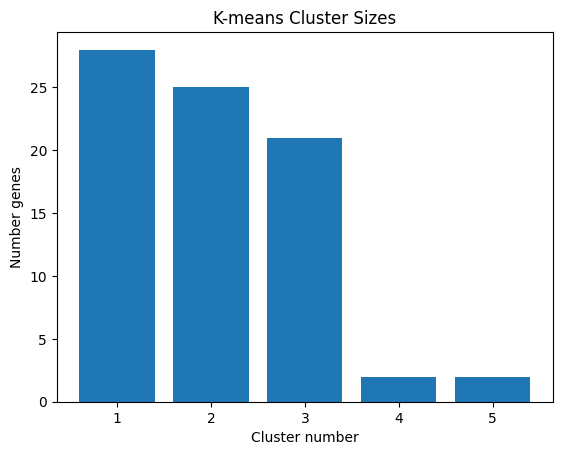

In [9]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
  
# Read in the DataFrame 
df = pd.read_csv('kmeans.csv') 
  
# creating a histogram 
plt.bar(df['cluster number'],df['gene count']) 
plt.title("K-means Cluster Sizes")
plt.ylabel("Number genes")
plt.xlabel("Cluster number")

plt.show() 